In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

# Задание 1. Bias-variance trade-off
2 балла

Продемонстрируйте bias-variance trade-off для DecisionTreeRegressor при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию plot_regression_predictions (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

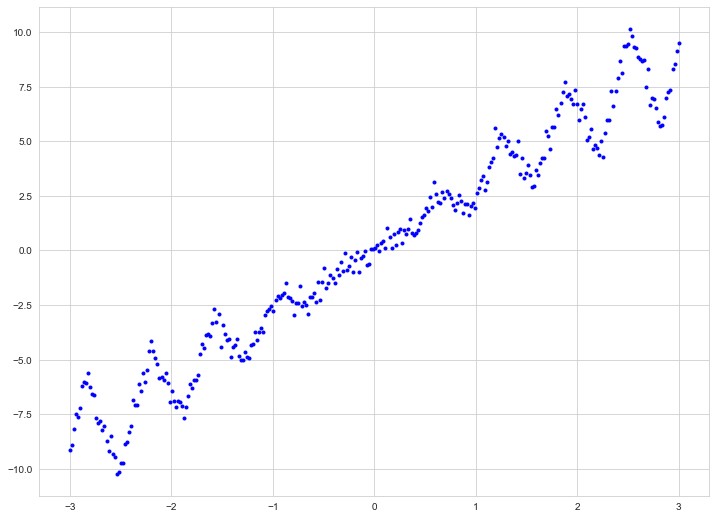

In [4]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [5]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):
1) Сделаем дерево глубиной 1

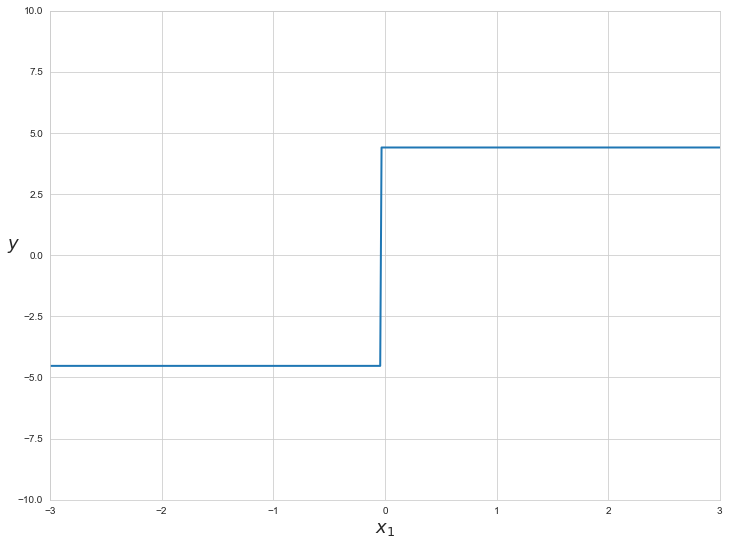

In [6]:
regTree = DecisionTreeRegressor(max_depth=1)
regTree = regTree.fit(X, y)
plot_regression_predictions(regTree, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")

видно, что оно явно недообучено, то есть высокий Bias

2) Сделаем дерево глубиной 5

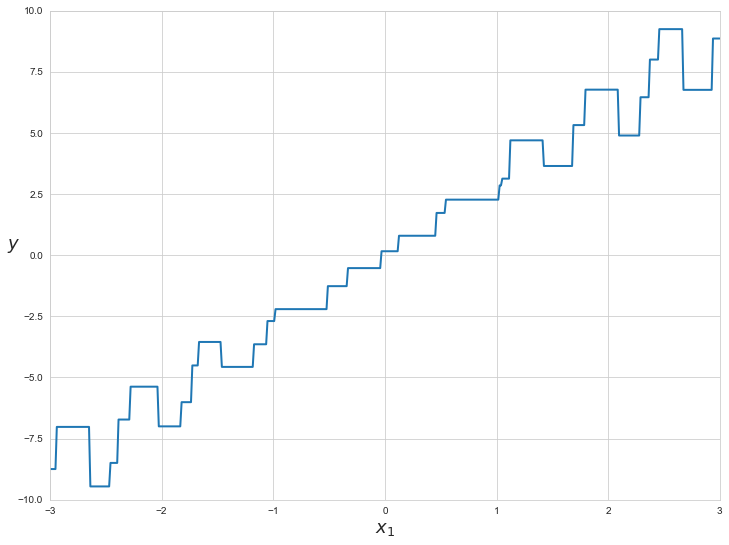

In [7]:
regTree = DecisionTreeRegressor(max_depth=5)
regTree = regTree.fit(X, y)
plot_regression_predictions(regTree, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")

уже ближе к истине, но все еще недообучено.

3) сделаем дерево глубиной 10

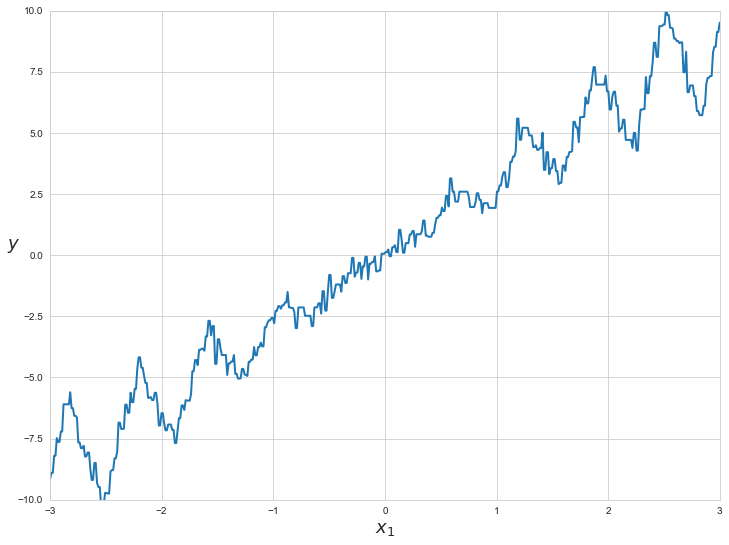

In [8]:
regTree = DecisionTreeRegressor(max_depth=10)
regTree = regTree.fit(X, y)
plot_regression_predictions(regTree, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")

очень похоже на правду! Сделаем для проверки древо глубиной 15


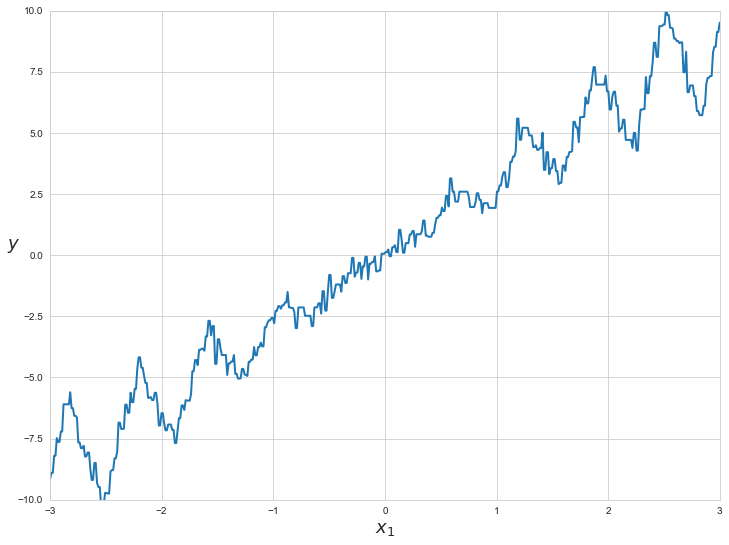

In [9]:
regTree = DecisionTreeRegressor(max_depth=10)
regTree = regTree.fit(X, y)
plot_regression_predictions(regTree, X, y, axes=[-3, 3, -10, 10], ylabel="$y$")

похоже, что переобучается, в более-менее ровной части какие-то завихрения явно лишние. высокий variance

# Задание 2. Random forest
Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

## Задание 2. 1. Простое ансамблирование
1 балла

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью p (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения p. Вам может быть полезная следующая формула:

In [10]:
import math #импортнула для подсчета факториалов
probability = 0 #ввела переменную для вероятности, которая будет представлять собой сумму
p = float(input()) # можно вводить p с клавиатуры
for i in range(51,102):
    c = math.factorial(101)/(math.factorial(i) * math.factorial (101 - i)) #считает количество сочетаний для i
    prob_i = c * (p ** i) * ((1 - p) ** (101 - i)) #считает слагаемое для этого i
    probability+=prob_i #прибавляет слагаемое к итоговому значению вероятности
print(probability)

0.5
0.49999999999999994


In [11]:
X = [x * 0.1 for x in range(0, 11,1)] #возьмем значения вероятностей от 0 до 1

In [12]:
#найдем вероятности правильного ответа для каждой вероятности правильного предсказания одной моделью
y = []
for p in X:
    probability = 0 #ввела переменную для вероятности, которая будет представлять собой сумму
    for i in range(51,102):
        c = math.factorial(101)/(math.factorial(i) * math.factorial (101 - i)) #считает количество сочетаний для i
        prob_i = c * (p ** i) * ((1 - p) ** (101 - i)) #считает слагаемое для этого i
        probability+=prob_i #прибавляет слагаемое к итоговому значению вероятности
    y.append(probability)

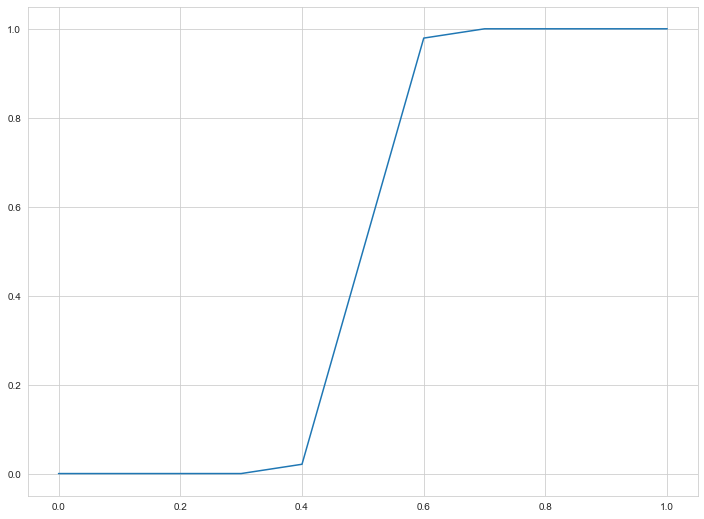

In [13]:
plt.plot(X, y) #построим график

любопытно, что при переходе от 0.4 к 0.6 для вероятности верного предсказания отдельной моделью мы наблюдаем резкий скачок эффективности и для ансамбля. причем при вероятности предсказания одной моделью 0.6 101 модель предсказывает почти с вероятностью 1! это хорошо и говорит в пользу того, чтобы использовать ансамбли!

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект p = 0.65. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [18]:
 #ввела переменную для вероятности, которая будет представлять собой сумму
p = 0.65
y = []
for n in range(2, 102):
    m = n // 2 + 1
    probability = 0
    for i in range(m,n):
        c = math.factorial(n - 1)/(math.factorial(i) * math.factorial (n - 1 - i)) #считает количество сочетаний для i
        prob_i = c * (p ** i) * ((1 - p) ** (n - 1 - i)) #считает слагаемое для этого i
        probability+=prob_i #прибавляет слагаемое к итоговому значению вероятности
    y.append(probability)


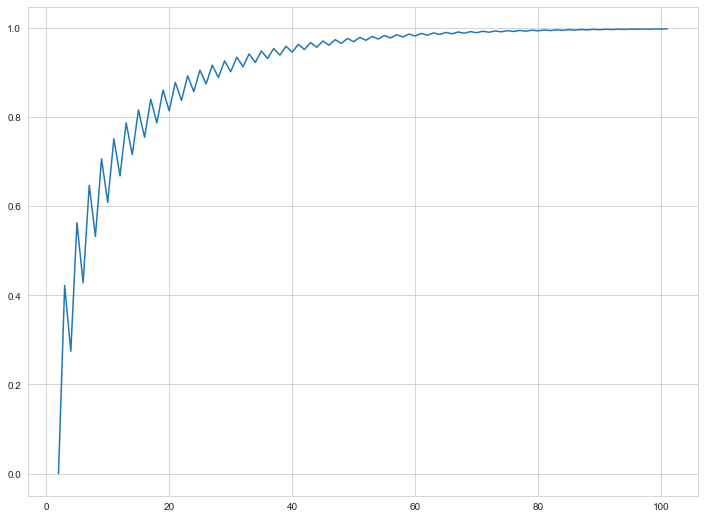

In [19]:
X = [x for x in range(2, 102)]
plt.plot(X, y)

по идее чем больше моделей, тем лучше работает ансамбль, но тут видно, что после 40 моделей вероятность положительного ответа ансамблем практически выходит на плато. 

## Задание 2. 2. Реализация простого RF
4 балла

Реализуйте свой собственный класс RandomForestClassifierCustom, используя в качестве базовой модели DecisionTreeClassifier из sklearn.

Небольшое описание:

Используйте приведенный ниже код

В методе fit в цикле (i от 0 до n_estimators-1):

Зафиксируйте генератор случайных чисел следующим образом np.random.seed(random_state + i). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты

После чего выберите max_features признаков без возвращения/without replacement, сохраните список выбранных признаков (их индексов) в self.feat_ids_by_tree

Также создайте псевдовыборку при помощи бутстрэпа (выбор с возвращением/with replacement) из тренировочных данных. Может помочь функция np.random.choice и ее аргумент replace

Обучите дерево решений с параметрами, заданными в конструкторе класса max_depth, max_features и random_state на полученной псевдовыборке.

Метод fit должен возвращать текущий экземпляр класса RandomForestClassifierCustom, то есть self (все по-взрослому, как в sklearn)

В методе predict_proba мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте self.feat_ids_by_tree. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода predict_proba и потом усреднять эти вероятности, или к примеру пользоваться методом predict и также считать среднее.

In [20]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(0, self.n_estimators - 1):
            np.random.seed(random_state + i)
            ids_by_tree = np.random.choice(range(0, int(X.size / len(X))), size=max_features, replace=False) #создаю список номеров фичей для выборки
            sample_indexes = np.random.choice(range(0, int(len(X))), size = len(X), replace=True) #создаю список индексов сэмплов из Х
            X_pd = pd.DataFrame(X)
            y_pd =pd.DataFrame(y) #сделаем Х датафрйемом пандас
            X_subset = X_pd.loc[sample_indexes, feat_ids_by_tree] #создадим сабсет с нужными колонками и строками
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state = self.random_state)
            tree_fitted = tree.fit(X_pd,y_pd)
            self.trees.append(tree_fitted)
            self.feat_ids_by_tree.append(ids_by_tree)
        return self



    def predict_proba(self, X):
        X_pd = pd.DataFrame(X)
        proba_list = []
        for j in range(len(X)): #для каждого предсказания в наборе найдем
            class0_sum = 0
            class1_sum = 0
            for i in range(0, len(self.trees)): #для каждого дерева из списка обученных деревьев
                tree = self.trees[i] # берем дерево по индексу
                y_pred = tree.predict(X_pd.loc[:, self.feat_ids_by_tree[i]]) #предсказываем на нем y по всему датасету Х, но только с признаками, на которых работало это дерево
                if y_pred[j] == 0: #если у этого дерева предсказание с индексом j - это класс 0 увеличиваем число найденных нулей
                    class0_sum+=1
                elif y_pred[j] == 1:#если 1 - увеличиваем число предсказанных в этой позиции единиц
                    class1_sum +=1
            prob0 = class0_sum/len(self.trees) #находим вероятность нахождения нуля
            prob1 = class1_sum/len(self.trees) #и вероятность нахождения 1
            proba_list.append([prob0, prob1]) #кладем пару вероятностей в список
            

        return np.array(proba_list) #выведем список
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции plot_decision_boundary (см. примеры в лекции).

In [21]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

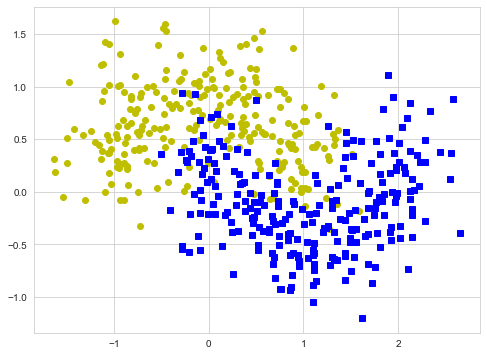

In [22]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [23]:
clf = RandomForestClassifierCustom(max_depth=5, max_features=2)
plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True)

ZeroDivisionError: division by zero

В общем, мой случайный лес не работает. Если Вы сможете указать мне на ошибку, я была бы очень рада.

# Задание 2. 3. Корреляция базовых моделей
3 балла

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр max_features на корреляцию базовых моделей в случайном лесу из sklearn. В качестве примера будем использовать датасет breast_cancer. Для расчета корреляций используйте приведенную ниже функцию base_model_pair_correlation. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [24]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [32]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape #узнаем сколько у нас фичей, их 30

(426, 30)

In [53]:
clf = RandomForestClassifier(max_features =2) #обучим рандомный лес с использованием 2 фичи
clf.fit(X_train, y_train)
max_features2 = base_model_pair_correlation(clf, X_test)


array([0.70972718, 0.80677931, 0.73620871, ..., 0.67266675, 0.85768719,
       0.73248396])

In [51]:
clf = RandomForestClassifier(max_features = 5 ) #с использованием 5 фичей
clf.fit(X_train, y_train)
max_features5 =  base_model_pair_correlation(clf, X_test)


array([0.78846154, 0.79327173, 0.80677931, ..., 0.78643396, 0.81669572,
       0.86313895])

In [59]:
clf = RandomForestClassifier(max_features = 10) #с использованием 10 фичей
clf.fit(X_train, y_train)
max_features10 =base_model_pair_correlation(clf, X_test)


(4950,)

In [58]:
clf = RandomForestClassifier(max_features = 20) #с использованием 20 фичей
clf.fit(X_train, y_train)
max_features20 =base_model_pair_correlation(clf, X_test)


(4950,)

In [57]:
clf = RandomForestClassifier(max_features = 30) #с использованием всех 30 фичей
clf.fit(X_train, y_train)
max_features30 =base_model_pair_correlation(clf, X_test)


(4950,)

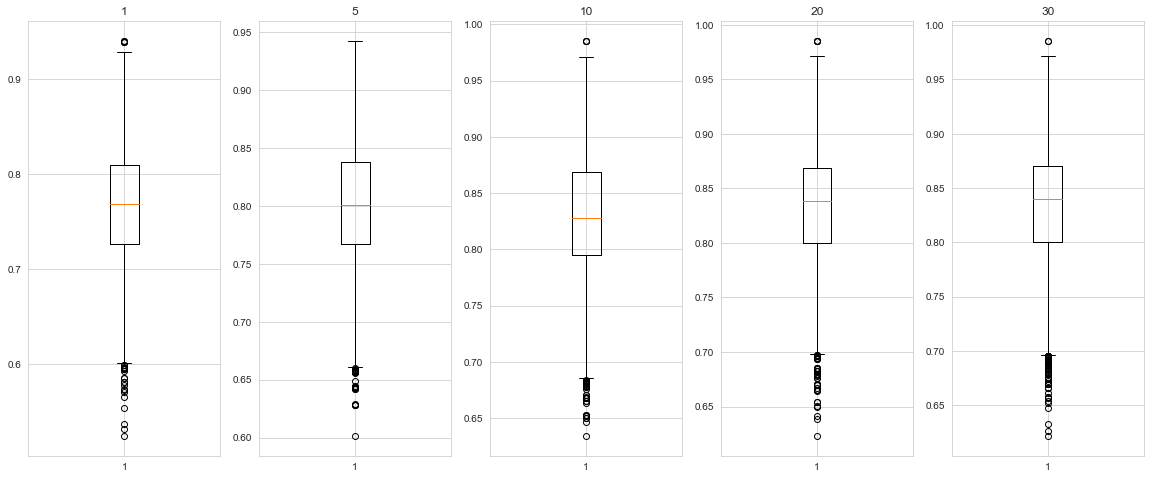

In [63]:
plt.figure(figsize=(20, 8)) #построим графики

plt.subplot(1, 5, 1)
plt.boxplot(max_features1)
plt.title("1")


plt.subplot(1, 5, 2)
plt.boxplot(max_features5)
plt.title("5")

plt.subplot(1, 5, 3)
plt.boxplot(max_features10)
plt.title("10")


plt.subplot(1, 5, 4)
plt.boxplot(max_features20)
plt.title("20")

plt.subplot(1, 5, 5)
plt.boxplot(max_features30)
plt.title("30")
   
plt.show()

в целом при max_features = 1 корреляции как будто меньше, чем при повышенных max_features

Теперь давайте посмотрим, как на это влияет параметр max_depth:

In [64]:
clf = RandomForestClassifier(max_features = 5, max_depth = 1) #обучим рандомный лес с использованием max depth = 1
clf.fit(X_train, y_train)
max_depth1 = base_model_pair_correlation(clf, X_test)

In [65]:
clf = RandomForestClassifier(max_features = 5, max_depth = 3) #обучим рандомный лес с использованием max depth = 3
clf.fit(X_train, y_train)
max_depth3 = base_model_pair_correlation(clf, X_test)

In [66]:
clf = RandomForestClassifier(max_features = 5, max_depth = 5) #обучим рандомный лес с использованием max depth = 5
clf.fit(X_train, y_train)
max_depth5 = base_model_pair_correlation(clf, X_test)

In [67]:
clf = RandomForestClassifier(max_features = 5, max_depth = 10) #обучим рандомный лес с использованием max depth = 10
clf.fit(X_train, y_train)
max_depth10 = base_model_pair_correlation(clf, X_test)

In [68]:
clf = RandomForestClassifier(max_features = 5, max_depth = 20) #обучим рандомный лес с использованием max depth = 20
clf.fit(X_train, y_train)
max_depth20 = base_model_pair_correlation(clf, X_test)

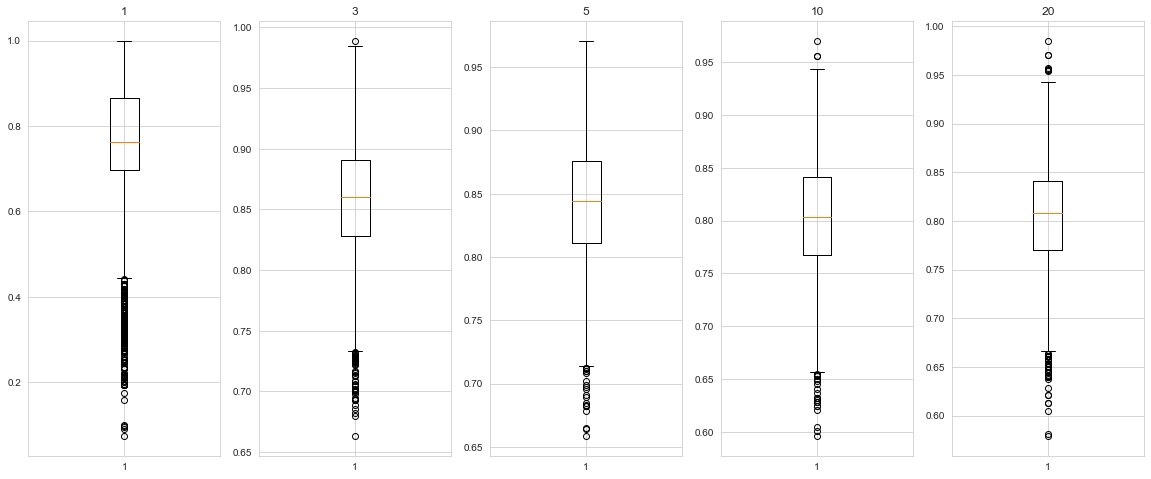

In [69]:
plt.figure(figsize=(20, 8)) #построим графики

plt.subplot(1, 5, 1)
plt.boxplot(max_depth1)
plt.title("1")


plt.subplot(1, 5, 2)
plt.boxplot(max_depth3)
plt.title("3")

plt.subplot(1, 5, 3)
plt.boxplot(max_depth5)
plt.title("5")


plt.subplot(1, 5, 4)
plt.boxplot(max_depth10)
plt.title("10")

plt.subplot(1, 5, 5)
plt.boxplot(max_depth20)
plt.title("20")
   
plt.show()

ощущение, что при увеличении глубины дерева корреляция немного снижается В целом в случайном лесе можно не ограничивать глубину деревьев, из--за корреляции базовых моделей все равно varience не опустится до нуля

# Задание 3 выполнила в отдельном блокноте через Colab, потому что ноутбук не хотел читать файл

# Задание 4. Определение оттока клиентов из телекома
6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты

Будем предсказывать, уйдет ли от нас клиент (переменная Churn?). Данные можно скачать здесь. Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель.

Задача минимум:

Выберите 2 модели — один случайный лес и один бустинг из приведенных ниже:

xgboost.XGBClassifier
xgboost.XGBRFClassifier — случайный лес от xgboost
lightgbm.LGBMClassifier
lightgbm.LGBMClassifier(boosting_type="rf") — случайный лес от lightgbm
catboost.CatBoostClassifier
И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее how to choose best hyperparameters for lightgbm. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [69]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [70]:
data.isnull().sum() #все значения не NA, это хорошо

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [71]:
data.dtypes #узнаем типы переменных

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

In [72]:
data.nunique() 

State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

видим, что есть название штатов и их 51 уникальных, можно перевести в чисельное значение. 

Видим, что номера телефоны уникальные у всех пользователей - вряд ли номер телефона влияет на уход, можно дропнуть эту колонку

Int'l Plan  и VMail Plan - колонки, где словом прописано yes-no, надо поменять на 1-0

Ну и колонку таргетную надо из False True перевести в 1-0.

Поехали

In [73]:
data = data.drop(['Phone'], axis=1)

In [74]:
data.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [75]:
data['State'] = data['State'].astype('category') #преобразуем колонку с именем штата в категориальную
cat_columns = data.select_dtypes(['category']).columns #выбираем все колонки с типом переменных категориальным
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes) #ко всем категX = pd.get_dummies(X)ориальным значениям применяем кодирование числом
data.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,16,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,35,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,31,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,35,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,36,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [76]:
data = pd.get_dummies(data) #быстро превратим все колонки где yes no в 1-0
data.head()

,State,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,...,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_False.,Churn?_True.
0,16,128,415,25,265.1,110,45.07,197.4,99,16.78,...,10.0,3,2.70,1,1,0,0,1,1,0
1,35,107,415,26,161.6,123,27.47,195.5,103,16.62,...,13.7,3,3.70,1,1,0,0,1,1,0
2,31,137,415,0,243.4,114,41.38,121.2,110,10.30,...,12.2,5,3.29,0,1,0,1,0,1,0
3,35,84,408,0,299.4,71,50.90,61.9,88,5.26,...,6.6,7,1.78,2,0,1,1,0,1,0
4,36,75,415,0,166.7,113,28.34,148.3,122,12.61,...,10.1,3,2.73,3,0,1,1,0,1,0


In [77]:
data = data.drop(['Int\'l Plan_no', 'VMail Plan_no'], axis=1)

In [78]:
data = data.drop(['Churn?_False.'], axis=1)
data.head()

,State,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan_yes,VMail Plan_yes,Churn?_True.
0,16,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,1,0
1,35,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,1,0
2,31,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0
3,35,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0,0
4,36,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1,0,0


In [79]:
data.head()

,State,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int'l Plan_yes,VMail Plan_yes,Churn?_True.
0,16,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,1,0
1,35,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,1,0
2,31,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,0
3,35,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0,0
4,36,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1,0,0


In [80]:
data = data.rename(columns = {'Int\'l Plan_yes': 'Int Plan',  'VMail Plan_yes': 'VMail Plan', 'Churn?_True.': 'Churn'})
X = data.drop(['Churn'], axis=1)
X.head()

,State,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int Plan,VMail Plan
0,16,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,1
1,35,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,1
2,31,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0
3,35,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,1,0
4,36,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,1,0


In [81]:
y = data['Churn']

In [287]:
y.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #разделим на трейн и тест
X_train

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Int Plan,VMail Plan
367,45,415,0,78.2,127,13.29,253.4,108,21.54,255.0,100,11.48,18.0,3,4.86,1,0,0
3103,115,415,0,195.9,111,33.30,227.0,108,19.30,313.2,113,14.09,13.2,1,3.56,2,0,0
549,121,408,31,237.1,63,40.31,205.6,117,17.48,196.7,85,8.85,10.1,5,2.73,4,0,1
2531,180,415,0,143.3,134,24.36,180.5,113,15.34,184.2,87,8.29,10.1,4,2.73,1,0,0
2378,112,510,0,206.2,122,35.05,164.5,94,13.98,140.3,101,6.31,12.6,7,3.40,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,106,510,0,274.4,120,46.65,198.6,82,16.88,160.8,62,7.24,6.0,3,1.62,1,0,0
1130,122,415,0,35.1,62,5.97,180.8,89,15.37,251.6,58,11.32,12.7,2,3.43,1,0,0
1294,66,408,0,87.6,76,14.89,262.0,111,22.27,184.6,125,8.31,9.2,5,2.48,1,0,0
860,169,415,0,179.2,111,30.46,175.2,130,14.89,228.6,92,10.29,9.9,6,2.67,2,0,0


## Пробуем бустинг от lightgbm

In [26]:
boo = lightgbm.LGBMClassifier()
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_score(y_test, y_pred)  #считаем F1 для бинарной класификации

0.8036529680365296

In [28]:
boo.score(X_test, y_test) #можно еще accuracy посчитать

0.9484412470023981

По умолчанию листьев max_leaves 31, можно повысить для достижения лучшей accuracy

In [29]:
boo = lightgbm.LGBMClassifier(num_leaves=40) #поставим, например, 40
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_score(y_test, y_pred) 

0.8161434977578476

In [30]:
boo.score(X_test, y_test)

0.9508393285371702

Узнаем с помощью GridSearch можно ли улучшить скор с помощью регуляции числа листьев и какое число листьев дает лучший score

In [198]:
from sklearn.model_selection import GridSearchCV
boo = lightgbm.LGBMClassifier()
parametres = {'num_leaves': range(20, 100, 5)} #задаем набор параметров, из которых хотим выбрать оптимальные
grid_search_cv_clf = GridSearchCV(boo, parametres, cv = 3)
grid_search_cv_clf.fit(X_train, y_train)  #GridSearchCV прогоняет все эти параметры и создает деревья с ними на нашей трейн выборке

best_clf = grid_search_cv_clf.best_estimator_ #лучшее дерево сохраняем
score = best_clf.score(X_test, y_test) #оценим работу лучшего дерева на тесте
score

0.9520383693045563

In [199]:
grid_search_cv_clf.best_params_

{'num_leaves': 50}

оказывается, если взять число листьев 50 получается вообще хорошо

Посчитаем и f1. оказывается, она тоже немного улучшилась

In [266]:
boo = lightgbm.LGBMClassifier(num_leaves=50) 
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_best1 = f1_score(y_test, y_pred) 
f1_best1

0.8214285714285715

Можно еще уменьшить learning rate, по умолчанию она 0.1

In [201]:
from sklearn.model_selection import GridSearchCV 
boo = lightgbm.LGBMClassifier()
parametres = {'num_leaves': [50], 'learning_rate': [0.001, 0.01, 0.05, 0.07]} #задаем набор параметров, из которых хотим выбрать оптимальные
grid_search_cv_clf = GridSearchCV(boo, parametres, cv = 3)
grid_search_cv_clf.fit(X_train, y_train)  #GridSearchCV прогоняет все эти параметры и создает деревья с ними на нашей трейн выборке

best_clf = grid_search_cv_clf.best_estimator_ #лучшее дерево сохраняем
score = best_clf.score(X_test, y_test) #оценим работу лучшего дерева на тесте
score

0.9496402877697842

In [202]:
grid_search_cv_clf.best_params_

{'learning_rate': 0.05, 'num_leaves': 50}

Ну нет, от изменения learning rate лучше не становится. Пробуем сделать dart

In [221]:
boo = lightgbm.LGBMClassifier(num_leaves=50,boosting_type = 'dart') 
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_score(y_test, y_pred)

0.8108108108108107

In [222]:
boo.score(X_test, y_test)

0.9496402877697842

Пробую найти самый-самый лучший вариант из всех

In [31]:
from sklearn.model_selection import GridSearchCV 
boo = lightgbm.LGBMClassifier()
parametres = {'num_leaves': range(20, 100, 5), 'learning_rate': [0.001, 0.01, 0.05, 0.07, 0.1], 'boosting_type': ['dart', 'goss', 'gbdt']} #задаем набор параметров, из которых хотим выбрать оптимальные
grid_search_cv_clf = GridSearchCV(boo, parametres, cv = 3)
grid_search_cv_clf.fit(X_train, y_train)  #GridSearchCV прогоняет все эти параметры и создает деревья с ними на нашей трейн выборке

best_clf = grid_search_cv_clf.best_estimator_ #лучшее дерево сохраняем
score = best_clf.score(X_test, y_test) #оценим работу лучшего дерева на тесте
score

0.9508393285371702

In [32]:
grid_search_cv_clf.best_params_

{'boosting_type': 'dart', 'learning_rate': 0.1, 'num_leaves': 25}

In [33]:
Посчитаю f1 с такими параметрами дерева.

SyntaxError: invalid syntax (<ipython-input-33-0135a5a56f01>, line 1)

In [34]:
boo = lightgbm.LGBMClassifier(num_leaves=20, boosting_type = 'dart') 
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_score(y_test, y_pred)

0.8054298642533937

а все равно получается, что метрики, полученные на дефолтном boostertype и num_leaves = 50 лучшие

## Пробуем случайный лес из этой же библиотеки

In [289]:
from sklearn.metrics import f1_score
RF = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
f1_score(y_test, y_pred)


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [227]:
RF.score(X_test, y_test)

0.9376498800959233

Попробую поменять bagging freq и bagging_fraction

In [267]:
from sklearn.metrics import f1_score
RF = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=10, bagging_fraction=0.7, random_state=SEED)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
f1_best2=f1_score(y_test, y_pred)
f1_best2

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


0.7916666666666667

In [265]:
score2 = RF.score(X_test, y_test)
score2

0.9400479616306955

### Подведу итоги. Мои лучшие метрики бустингом и случайным лесом LightGBM

In [269]:
Classifiers = pd.Series(['booster', 'random forest'])
test_score = pd.Series([score, score2])
f1scores = ([f1_best1, f1_best2])
my_data = pd.DataFrame({'Classifiers': Classifiers, 'test_score': test_score, 'f1_score': f1scores})

my_data

,Classifiers,test_score,f1_score
0,booster,0.938849,0.821429
1,random forest,0.940048,0.791667


# Пробую другой EDA, удалив коррелирующие фичи!

<AxesSubplot:>

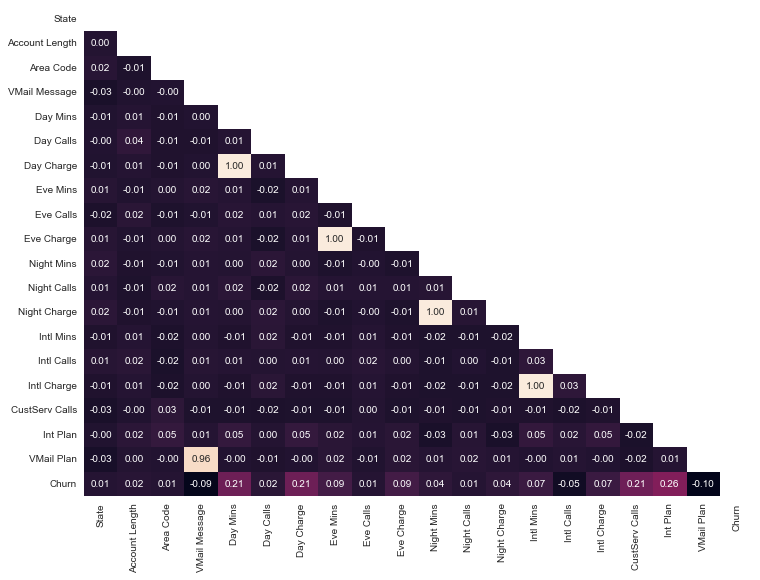

In [63]:
sns.heatmap(data.corr(method='pearson'),annot=True,fmt='.2f',mask=np.triu(data.corr(method='pearson')),cbar=False)

Я удалю колонки Day Mins Eve Mins Night Mins Ind Mins так как они коррелируют 100% с другими. И удалю VMail Message так как 0.96 корреляция с Vmail pplan

In [82]:
data = data.drop(['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins', 'VMail Message'], axis=1)


<AxesSubplot:>

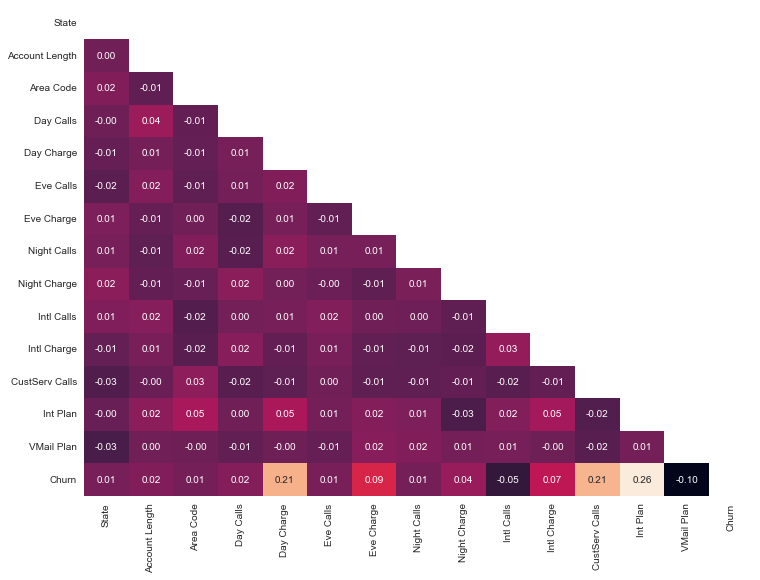

In [83]:
sns.heatmap(data.corr(method='pearson'),annot=True,fmt='.2f',mask=np.triu(data.corr(method='pearson')),cbar=False)

In [88]:
X = data.drop(['Churn'], axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #разделим на трейн и тест
X_train


,State,Account Length,Area Code,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,CustServ Calls,Int Plan,VMail Plan
367,20,45,415,127,13.29,108,21.54,100,11.48,3,4.86,1,0,0
3103,8,115,415,111,33.30,108,19.30,113,14.09,1,3.56,2,0,0
549,36,121,408,63,40.31,117,17.48,85,8.85,5,2.73,4,0,1
2531,39,180,415,134,24.36,113,15.34,87,8.29,4,2.73,1,0,0
2378,37,112,510,122,35.05,94,13.98,101,6.31,7,3.40,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,13,106,510,120,46.65,82,16.88,62,7.24,3,1.62,1,0,0
1130,38,122,415,62,5.97,89,15.37,58,11.32,2,3.43,1,0,0
1294,37,66,408,76,14.89,111,22.27,125,8.31,5,2.48,1,0,0
860,11,169,415,111,30.46,130,14.89,92,10.29,6,2.67,2,0,0


## Пробуем теперь бустинг

In [89]:
boo = lightgbm.LGBMClassifier()
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_score(y_test, y_pred) 

0.8181818181818181

In [90]:
boo.score(X_test, y_test) #обе метрики чуть лучше

0.9520383693045563

In [101]:
boo = lightgbm.LGBMClassifier(num_leaves=50) #поставим, например, 50 листьев
boo.fit(X_train, y_train)
y_pred = boo.predict(X_test)
f1_score_EDA2 = f1_score(y_test, y_pred) 
f1_score_EDA2

0.8235294117647057

In [102]:
boo.score(X_test, y_test)

0.9532374100719424

In [99]:
from sklearn.model_selection import GridSearchCV
boo = lightgbm.LGBMClassifier()
parametres = {'num_leaves': range(20, 100, 5)} #задаем набор параметров, из которых хотим выбрать оптимальные
grid_search_cv_clf = GridSearchCV(boo, parametres, cv = 10)
grid_search_cv_clf.fit(X_train, y_train)  #GridSearchCV прогоняет все эти параметры и создает деревья с ними на нашей трейн выборке

best_clf = grid_search_cv_clf.best_estimator_ #лучшее дерево сохраняем
scoreEDA2 = best_clf.score(X_test, y_test) #оценим работу лучшего дерева на тесте
scoreEDA2 #ну вот судя по скору мы и нашли это лучшее решение, то есть число листьев = 50

0.9532374100719424

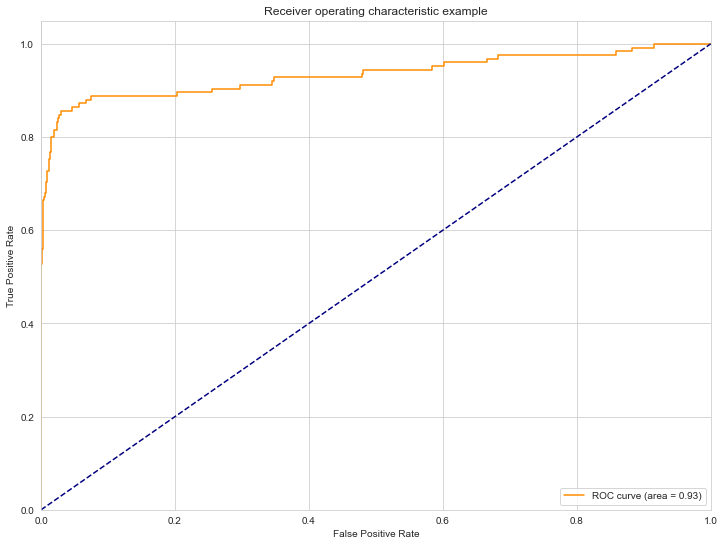

0.9341269393511988

In [105]:
y_predicted_prob = best_clf.predict_proba(X_test)
from sklearn.metrics import roc_curve, auc #изобразим ROC-кривую, пунктир - самый плохой вариант
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

roc_auc = auc(fpr, tpr) #посчитаем еще roc auc, она тоже теперь хороша!
roc_auc

# Задание 5. Рисуем
дополнительно 0.5 балла

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

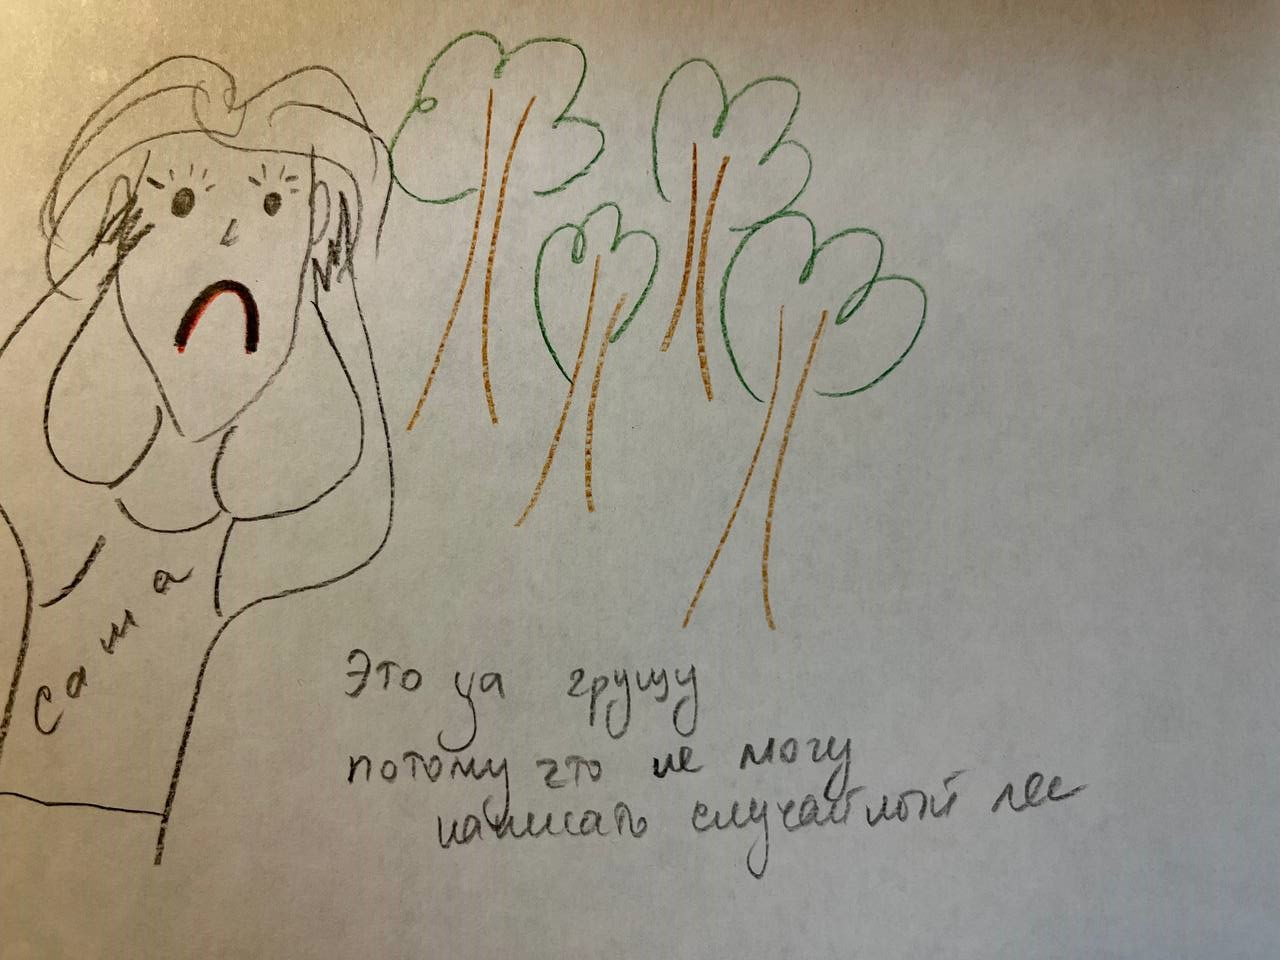